In [ ]:
!pip install "arize-phoenix[experimental]" gcsfs nltk langchain llama_index openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.5/943.5 kB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.5/221.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 44.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.0/269.0 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 26.2 MB/s eta 0:00:00
     ━━━━━

In [ ]:
import json
import os
from getpass import getpass
from urllib.request import urlopen

import openai
import pandas as pd
import phoenix as px
from gcsfs import GCSFileSystem
from langchain.chat_models import ChatAnyscale
from llama_index import (
    ServiceContext,
    StorageContext,
    load_index_from_storage,
    set_global_handler,
)
from llama_index.embeddings import OpenAIEmbedding
from llama_index.graph_stores.simple import SimpleGraphStore
from llama_index.llms.anyscale import Anyscale
from tqdm import tqdm

# Configure Your OpenAI API Key

Set your OpenAI API key if it is not already set as an environment variable.

In [ ]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

🔑 Enter your OpenAI API key: ··········


# Sign up for Anyscale and Check Available Endpoints

Get your free token for an endpoint from Anyscale here, with your email
https://www.anyscale.com/endpoints

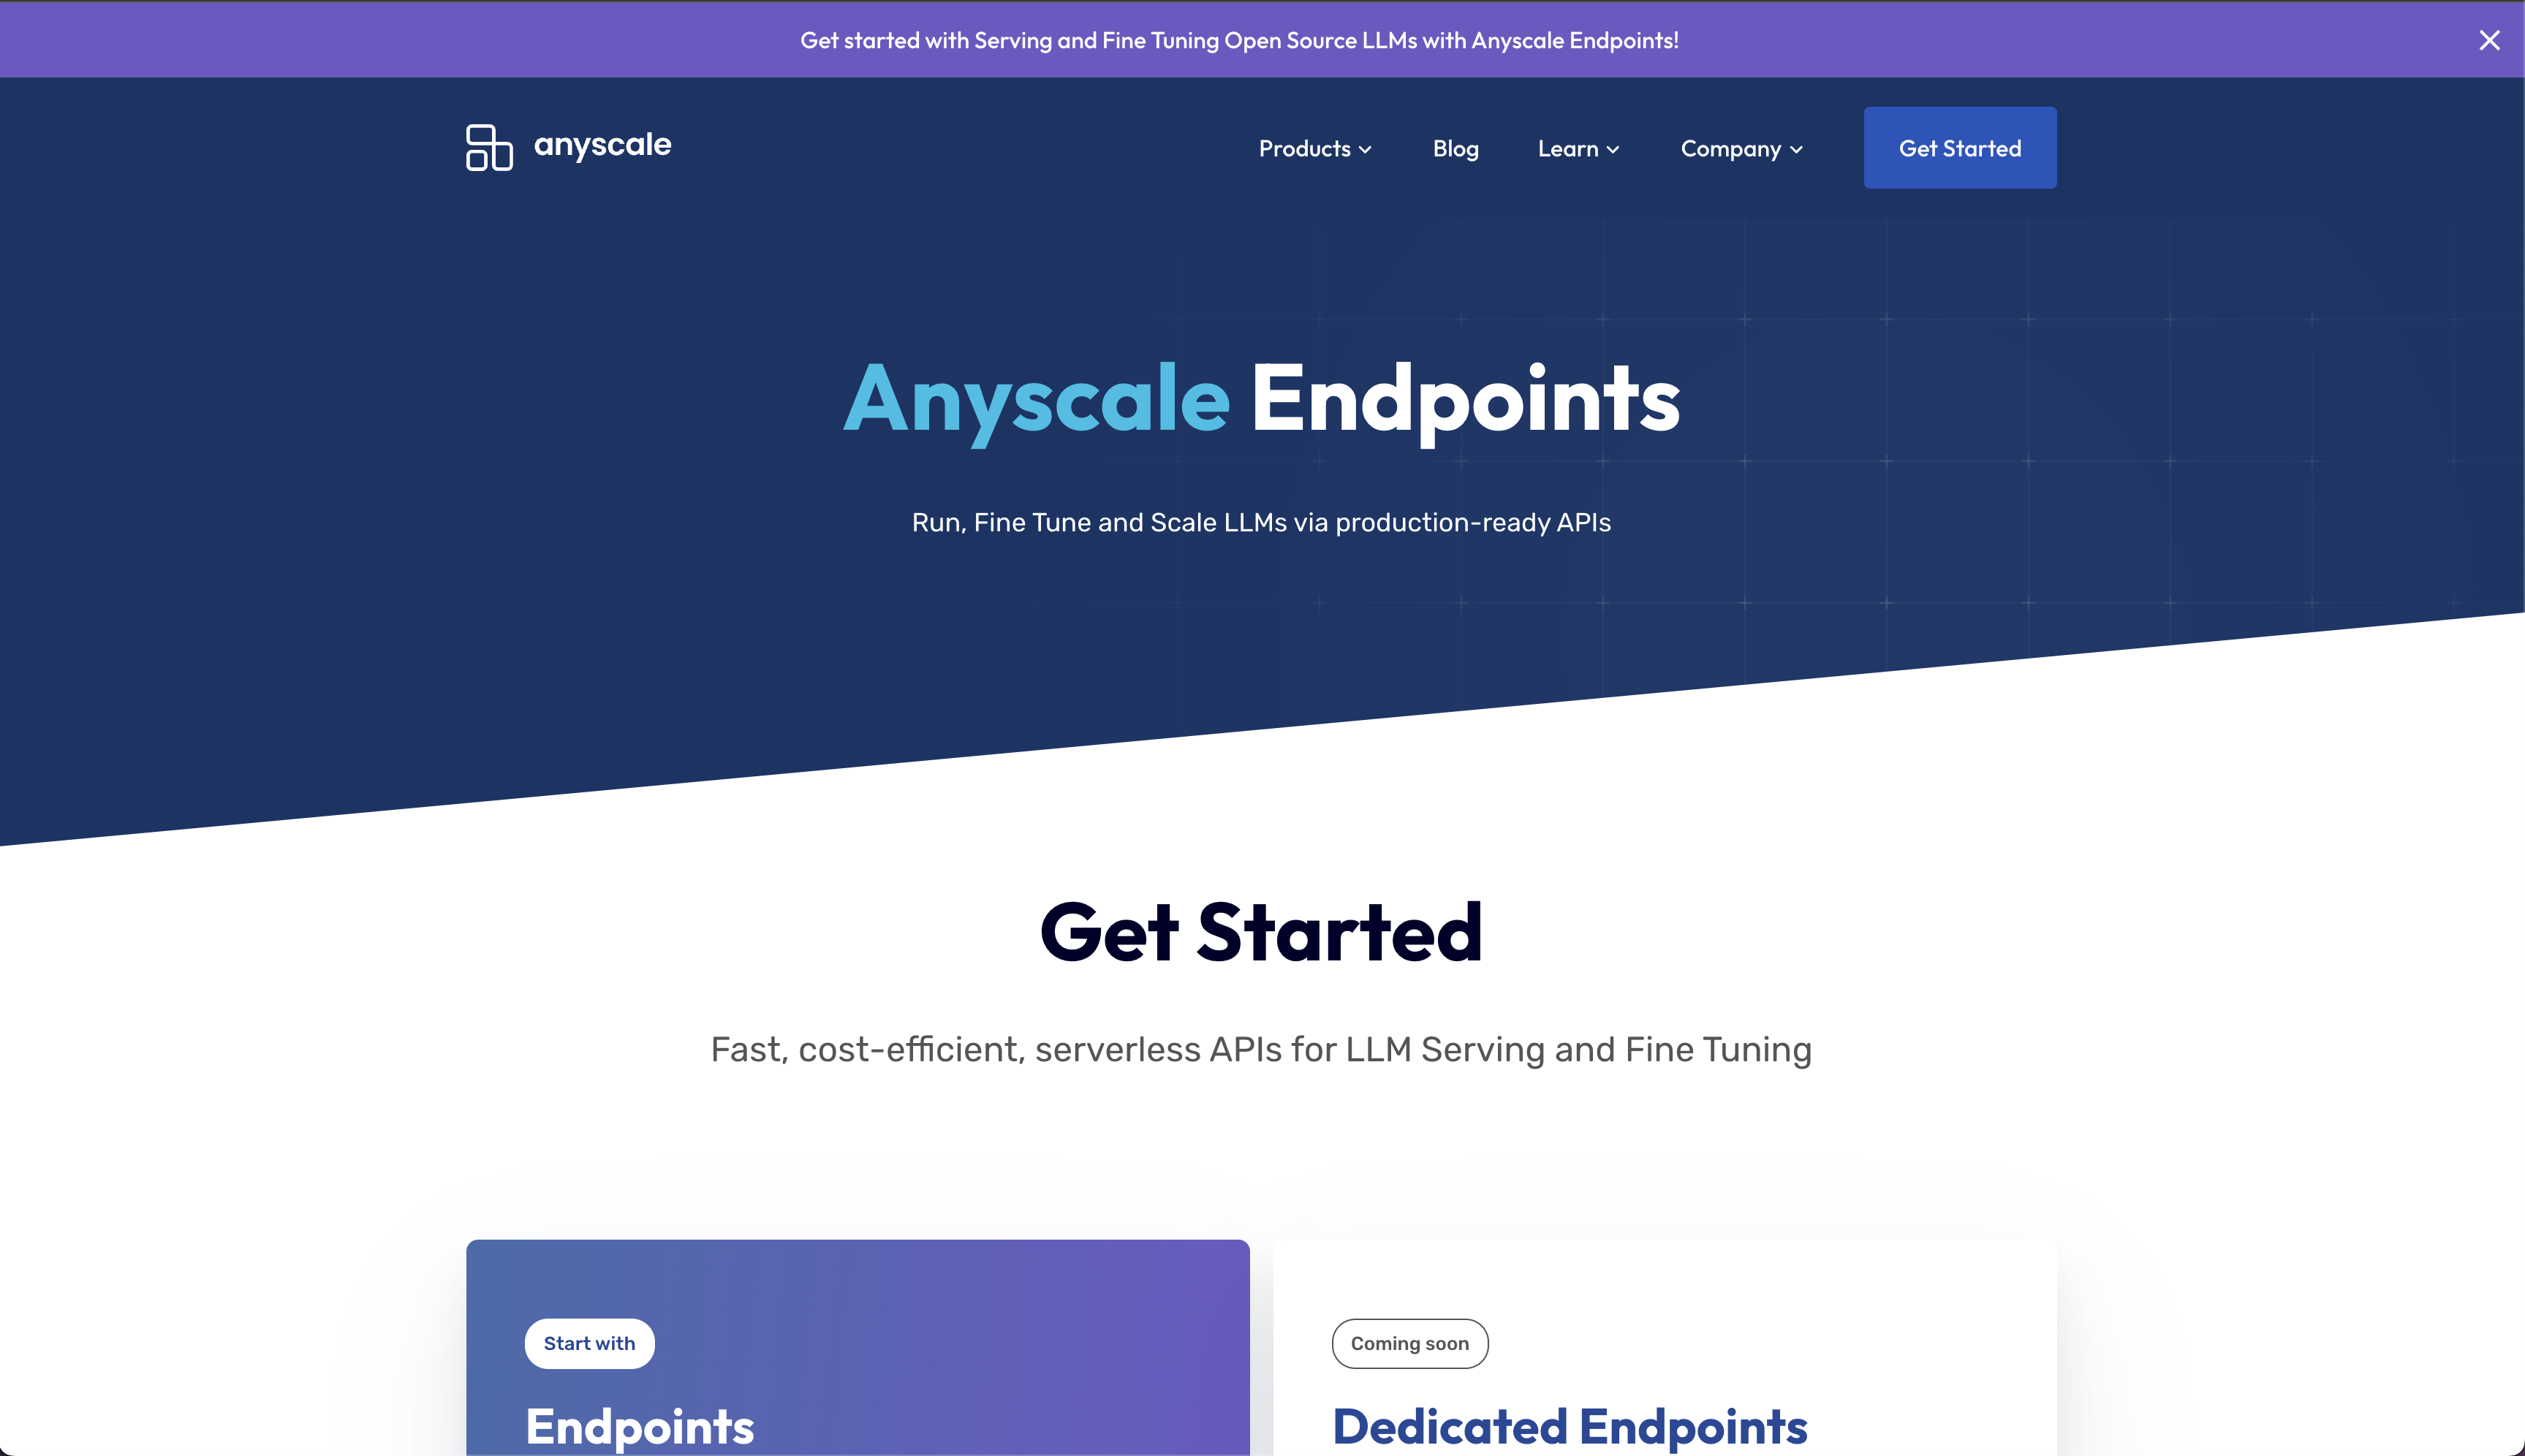

In [ ]:
# ANYSCALE_ENDPOINT_TOKEN = "INSERT_ANYSCALE_ENDPOINT_TOKEN"
ANYSCALE_ENDPOINT_TOKEN = "secret_ramy6miafz45heuf3hff21babw"


# List all models available
ChatAnyscale.get_available_models(anyscale_api_key=ANYSCALE_ENDPOINT_TOKEN)

{'BAAI/bge-large-en-v1.5',
 'HuggingFaceH4/zephyr-7b-beta',
 'Meta-Llama/Llama-Guard-7b',
 'Open-Orca/Mistral-7B-OpenOrca',
 'codellama/CodeLlama-34b-Instruct-hf',
 'meta-llama/Llama-2-13b-chat-hf',
 'meta-llama/Llama-2-13b-chat-hf:agentinstruct:8VRVuzi',
 'meta-llama/Llama-2-70b-chat-hf',
 'meta-llama/Llama-2-70b-chat-hf:agentinstruct:u4sUVDS',
 'meta-llama/Llama-2-7b-chat-hf',
 'meta-llama/Llama-2-7b-chat-hf:dummytest:RPXnzUc',
 'meta-llama/Llama-2-7b-chat-hf:hotpotqa:ALpFD3k',
 'meta-llama/Llama-2-7b-chat-hf:hotpotqa_ai:LVeBgRf',
 'meta-llama/Llama-2-7b-chat-hf:kyle:UeHMfnQ',
 'meta-llama/Llama-2-7b-chat-hf:kyle:uPkOwa8',
 'meta-llama/Llama-2-7b-chat-hf:trivia:bEUjHwt',
 'meta-llama/Llama-2-7b-chat-hf:trivia:lhLWN58',
 'mistralai/Mistral-7B-Instruct-v0.1',
 'thenlper/gte-large'}

# Grab some data

In [ ]:
queries_url = "http://storage.googleapis.com/arize-assets/phoenix/datasets/unstructured/llm/context-retrieval/arize_docs_queries.jsonl"
queries = []
with urlopen(queries_url) as response:
    for line in response:
        line = line.decode("utf-8").strip()
        data = json.loads(line)
        queries.append(data["query"])

sample_queries = queries[:3]

# Create Embeddings from Anyscale - General Text Embeddings (GTE) Large

In [ ]:
client = openai.OpenAI(
    base_url="https://api.endpoints.anyscale.com/v1", api_key=ANYSCALE_ENDPOINT_TOKEN
)

response = client.embeddings.create(
    input=sample_queries,
    model="thenlper/gte-large",
)

print("Payload Response:", response)
print("Embeddings Dimensions:")
print([len(embedding.embedding) for embedding in response.data])

Payload Response: CreateEmbeddingResponse(data=[Embedding(embedding=[0.019385933876037598, 0.01681603118777275, -0.037527896463871, -0.008741955272853374, -0.004740157164633274, 0.008310157805681229, 0.004601609893143177, 0.03189469128847122, 0.039446260780096054, 0.03053087554872036, -0.0007282725418917835, -0.014894724823534489, 0.021067852154374123, -0.03591504320502281, 0.0026163249276578426, 0.0217739325016737, -0.014848614111542702, -0.04685157164931297, -0.03791100159287453, -0.01048283837735653, 0.01575562171638012, 0.019031673669815063, -0.07856100797653198, -0.036247365176677704, -0.027624081820249557, 0.05103280395269394, 0.03434967249631882, -0.009840312413871288, 0.05185345187783241, 0.05228733643889427, -0.0019503545481711626, -0.013658690266311169, 0.014859532006084919, -0.03270558640360832, -0.03102041780948639, -0.03465888649225235, 0.034349314868450165, -0.01894351653754711, -0.03558109700679779, -0.031494930386543274, 0.0277215838432312, -0.029464440420269966, 0.0358

# Launch Phoenix and Build Llama RAG

In [ ]:
session = px.launch_app()

🌍 To view the Phoenix app in your browser, visit https://txfgn46n87a5-496ff2e9c6d22116-6006-colab.googleusercontent.com/
📺 To view the Phoenix app in a notebook, run `px.active_session().view()`
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


# Run this cell and Ignore the Error (Known Llama Issue)

The code did indeed run even though error message is displayed

In [ ]:
# Build knowledge base
file_system = GCSFileSystem(project="public-assets-275721")
index_path = "arize-assets/phoenix/datasets/unstructured/llm/llama-index/arize-docs/index/"
storage_context = StorageContext.from_defaults(
    fs=file_system,
    persist_dir=index_path,
    graph_store=SimpleGraphStore(),  # prevents unauthorized request to GCS
)

ERROR:gcsfs:_request non-retriable exception: Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket. Permission 'storage.objects.list' denied on resource (or it may not exist)., 401
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gcsfs/retry.py", line 114, in retry_request
    return await func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/gcsfs/core.py", line 423, in _request
    validate_response(status, contents, path, args)
  File "/usr/local/lib/python3.10/dist-packages/gcsfs/retry.py", line 101, in validate_response
    raise HttpError(error)
gcsfs.retry.HttpError: Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket. Permission 'storage.objects.list' denied on resource (or it may not exist)., 401
ERROR:gcsfs:_request non-retriable exception: Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket. Permission 

Enable Phoenix tracing within LlamaIndex by setting `arize_phoenix` as the global handler. This will mount Phoenix's [OpenInferenceTraceCallback](https://docs.arize.com/phoenix/integrations/llamaindex) as the global handler. Phoenix uses OpenInference traces - an open-source standard for capturing and storing LLM application traces that enables LLM applications to seamlessly integrate with LLM observability solutions such as Phoenix.

In [ ]:
set_global_handler("arize_phoenix")

We are now ready to instantiate our query engine that will perform retrieval-augmented generation (RAG). Query engine is a generic interface in LlamaIndex that allows you to ask question over your data. A query engine takes in a natural language query, and returns a rich response. It is built on top of Retrievers. You can compose multiple query engines to achieve more advanced capability  

In [ ]:
service_context = ServiceContext.from_defaults(
    llm=Anyscale(model="meta-llama/Llama-2-70b-chat-hf", api_key=ANYSCALE_ENDPOINT_TOKEN),
    embed_model=OpenAIEmbedding(),
)
index = load_index_from_storage(
    storage_context,
    service_context=service_context,
)
query_engine = index.as_query_engine()

[nltk_data] Downloading package punkt to /tmp/llama_index...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Run our queries and see them populate in Arize Phoenix

In [ ]:
for query in tqdm(sample_queries):
    query_engine.query(query)

100%|██████████| 3/3 [00:15<00:00,  5.23s/it]


And just for fun, ask your own question!

In [ ]:
response = query_engine.query("What is Arize and how can it help me as an AI and LLM Engineer?")
print(response)

  Arize is a machine learning observability platform that enables you to monitor, troubleshoot, and explain your models' performance. It provides real-time monitoring of model performance, supports delayed ground truth/feedback, and offers tracing and explainability features to help you root cause model failures or performance degradation. Additionally, Arize allows you to compare the performance of multiple models and provides metrics on data quality, model fairness, and bias. As an AI and LLM Engineer, Arize can help you ensure that your models are performing optimally, identify and address any issues or biases, and improve your overall model development and deployment process.


### Make sure to check out your traces and spans in the Phoenix Traces View
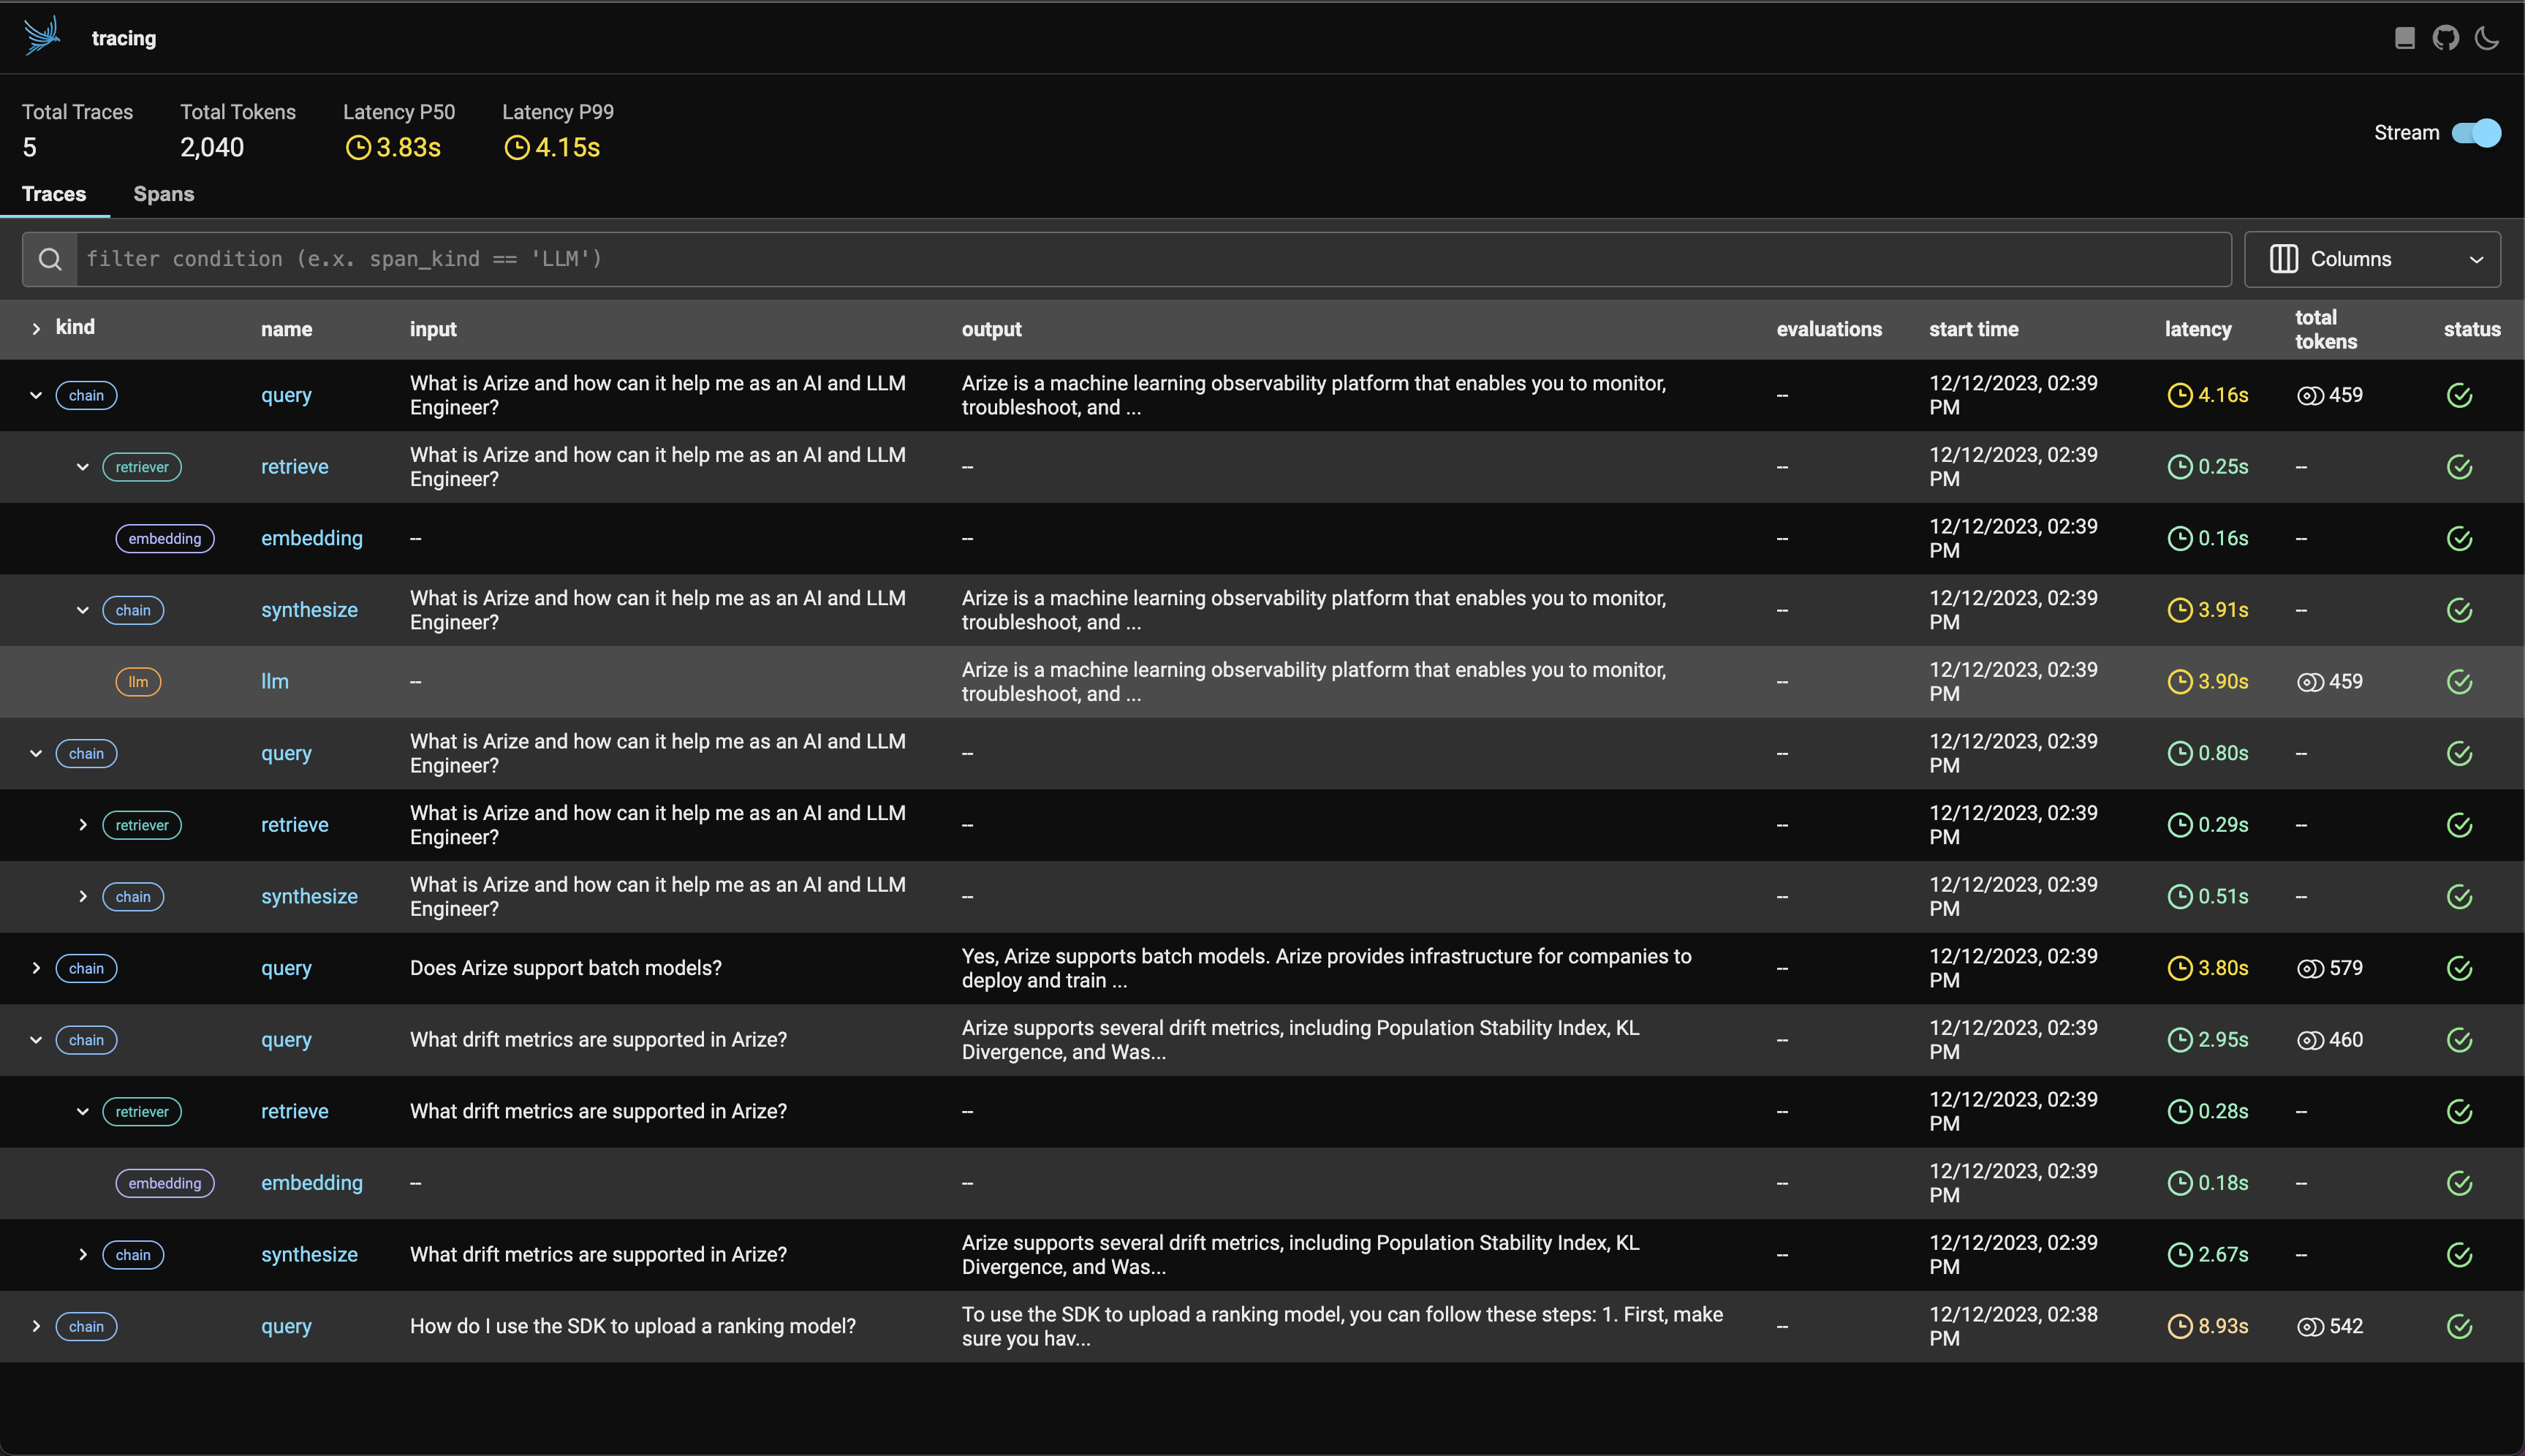

# Phoenix Embeddings View

Next we'll inspect our data at an application view using Arize Phoenix Embeddings and debugger. In this dataset we have prompt, responses, emebddings, LLM Evals, and more. We want to visualize our entire dataset in Phoenix Embeddings view

In [ ]:
data_url = (
    "https://storage.googleapis.com/arize-assets/fixtures/Embeddings/"
    "arize-demo-models-data/GENERATIVE/prompt-response/"
)
prod_df = pd.read_parquet(data_url + "df_queries_with_retrieved_doc_ids.parquet")

prod_df

,retrieval_text_1,pred_label,openai_relevance_0,euclidean_distance_1,response_vector,prompt_vector,text_similarity_0,euclidean_distance_0,text_similarity_1,openai_precision_1,...,prediction_id,llm_params,index_x,index_y,retrieved_doc_ids,prompt_token_count,response_token_count,total_token_count,is_hallucination,response_latency_ms
0,\nArize will attempt a dry run to validate you...,1,irrelevant,0.518850,"[0.003934279, -0.004175907, -0.00854287, -0.00...","[0.003934279, -0.004175907, -0.00854287, -0.00...",0.865398,0.518850,0.865398,0.0,...,28b85eb9-12d6-423c-9072-fde2500b3a13,"{""temperature"": 0.6, ""topP"": 0.84, ""topK"": 11,...",239,239,[6f13609f86067ae9a483fb205c53d15aaa3f8d62ed013...,14,30,44,True,10713
1,\nPlease follow this notebook tutorial where w...,1,irrelevant,0.675761,"[-0.0003646146, 0.022441763, 0.03381406, 0.004...","[-0.0003646146, 0.022441763, 0.03381406, 0.004...",0.773584,0.672927,0.771674,0.0,...,cfd8e61a-d54d-4a1c-940b-153c0adb1e30,"{""temperature"": 0.54, ""top_p"": 0.13, ""top_k"": ...",504,272,[4c2d50ad773bff3195866aa0c23fae2ec98203f718168...,9,43,52,False,1557
2,\n\n\n\n,1,irrelevant,0.668194,"[-0.026084378, -0.008777241, 0.004164621, 0.00...","[-0.026084378, -0.008777241, 0.004164621, 0.00...",0.782514,0.659524,0.776758,0.0,...,669cd221-53b6-41cb-a93d-f5799907c983,"{""temperature"": 0.19, ""topP"": 0.09, ""topK"": 28...",1248,359,[f71b97ab2b04db2ce539484e89d99eb274f82464b7bc6...,6,22,28,False,8572
3,"\n**Use the 'arize-demo-hotel-ranking' model, ...",1,irrelevant,0.637987,"[-0.005791928, 0.016765336, 0.011346804, 0.016...","[-0.005791928, 0.016765336, 0.011346804, 0.016...",0.802402,0.628646,0.796486,0.0,...,23ff67c9-b220-4e0e-b7d1-9ca6703a8001,"{""presence_penalty"": 0.07, ""temperature"": 0.38...",568,564,[096f842ed9e4be0a4d61c7e7b3ac9b54d88fa02ebcf1f...,12,106,118,False,6228
4,\n!.png>)View Source on Github\n\nArize class ...,1,irrelevant,0.596018,"[-0.0033874712, 0.0007436572, -0.003340942, 0....","[-0.0033874712, 0.0007436572, -0.003340942, 0....",0.832846,0.578193,0.822381,0.0,...,01468c34-a9f6-4575-9d30-9d288c11b013,"{""presence_penalty"": 0.27, ""temperature"": 0.39...",873,739,[42384e60ea30d4f4e7c44d7ca159e2d602bbd9a6c0e14...,10,14,24,True,14831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336,\nCustomize individual monitors to send alerts...,1,irrelevant,0.605772,"[0.025024261, 0.002969626, -0.0036206078, -0.0...","[0.025024261, 0.002969626, -0.0036206078, -0.0...",0.824572,0.592331,0.816520,0.0,...,b150345a-54c3-4c3d-a650-401b443d46f2,"{""temperature"": 0.49, ""topP"": 0.63, ""topK"": 24...",114,99,[7ca1fc69a37f7f6f2589a000dd41fd455489547309b40...,11,19,30,False,6342
1337,\n1. What type of data types do you support?\n...,1,relevant,0.582685,"[0.0068608904, 0.0021574239, -0.00613415, 0.00...","[0.0068608904, 0.0021574239, -0.00613415, 0.00...",0.844455,0.557754,0.830239,1.0,...,b261dd0f-ed37-43dd-918a-7df9ccfe706d,"{""presence_penalty"": 0.83, ""temperature"": 0.03...",345,1139,[eea88a4409fca1584f4b8f3a77a0cf666ad5faa301da2...,59,54,113,False,15060
1338,\nYou can configure monitors in **three ways**...,1,relevant,0.561338,"[-0.0074555757, -0.0035299195, -0.0024008758, ...","[-0.0074555757, -0.0035299195, -0.0024008758, ...",0.846281,0.554470,0.842450,1.0,...,70b33585-0690-4ce0-af18-01ca7e91f50a,"{""temperature"": 0.05, ""topP"": 0.03, ""topK"": 23...",99,86,[e8502435d7997a54c443727323d06b17c2ac9b6dcc165...,6,53,59,True,18272
1339,\nArize will attempt a dry run to validate you...,1,irrelevant,0.518850,"[0.003934279, -0.004175907, -0.00854287, -0.00...","[0.003934279, -0.004175907, -0.00854287, -0.00...",0.865398,0.518850,0.865398,0.0,...,53dc6add-27b0-411a-9a2e-120e23e320ab,"{""presence_penalty"": 0.54, ""temperature"": 0.31...",239,239,[6f13609f86067ae9a483fb205c53d15aaa3f8d62ed013...,14,30,44,True,17817


In [ ]:
tag_columns = [
    "cost_per_call",
    "euclidean_distance_0",
    "euclidean_distance_1",
    "instruction",
    "openai_precision_1",
    "openai_precision_2",
    "openai_relevance_0",
    "openai_relevance_1",
    "prompt_template",
    "prompt_template_name",
    "retrieval_text_0",
    "retrieval_text_1",
    "text_similarity_0",
    "text_similarity_1",
    "user_query",
    "is_hallucination",
    "llm_config_model_name",
    "retrieved_doc_ids",
]

schema = px.Schema(
    prediction_id_column_name="prediction_id",
    timestamp_column_name="prediction_ts",
    prediction_label_column_name="pred_label",
    tag_column_names=tag_columns,
    embedding_feature_column_names={
        "prompt_vector": px.EmbeddingColumnNames(
            vector_column_name="prompt_vector", raw_data_column_name="prompt_text"
        ),
    },
)

# Launch the Pheonix Embeddings View

In [ ]:
prod_ds = px.Dataset(dataframe=prod_df, schema=schema, name="production")
session = px.launch_app(primary=prod_ds)

🌍 To view the Phoenix app in your browser, visit https://txfgn46n87a8-496ff2e9c6d22116-6006-colab.googleusercontent.com/
📺 To view the Phoenix app in a notebook, run `px.active_session().view()`
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix
